### import

In [1]:
import ast
import wfdb
import h5py

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.decomposition import PCA         
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb  

### 데이터 읽기
- input 요소 있음. 콜렙은 c, 데스크탑은 D, 서버에서는 s 라고 치면됨. 대문자 소문자 상관없음.

In [2]:
res = os.getcwd()
base_path = os.path.join(res)
base_path_ptb = os.path.join(res, 'ptb_xl_data') + '/'
base_path_shp = os.path.join(res, 'sph_data') + '/'

In [3]:
df_ptb_origin = pd.read_csv(base_path_ptb + 'ptbxl_database.csv', encoding='utf-8',index_col='ecg_id')
df_sph_origin = pd.read_csv(base_path_shp + 'metadata.csv', encoding='utf-8', index_col='ECG_ID')

In [4]:
df_ptb_lead1 = pd.read_csv(base_path + '/custom_file/ashton_ptb_lead1.csv', index_col=0)

df_sph_lead1 = pd.read_csv(base_path + '/custom_file/ashton_sph_lead1.csv', index_col=0)

### PTB_xl, SHP 데이터 라벨링

In [5]:
#PTB 라벨링

#scp_codes 에서 AFIB에 해당하는 것에 대해서 라벨링
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: ast.literal_eval(x))
df_ptb_origin.scp_codes = df_ptb_origin.scp_codes.apply(lambda x: list(x.keys()))
df_ptb_origin['label'] = df_ptb_origin.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

print('df_ptb_origin : ',df_ptb_origin.label.value_counts())
print('-'*15)

#SHP 라벨링

# df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(lambda x: 1 if '50' in str(x) else 0) - 기존에 잘못된
# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers
# 'label' 컬럼 생성
df_sph_origin['label'] = df_sph_origin['AHA_Code'].apply(check_contains_50).astype(int)


print('df_sph_origin : ',df_sph_origin.label.value_counts())

df_ptb_origin :  label
0    20285
1     1514
Name: count, dtype: int64
---------------
df_sph_origin :  label
0    25095
1      675
Name: count, dtype: int64


### age, sex, label 컬럼과 심박수 데이터 합치기

In [6]:
df_ptb = pd.concat([df_ptb_origin[['age', 'sex', 'label']], df_ptb_lead1], axis=1)

df_sph_lead1.index = df_sph_origin.index
df_sph = pd.concat([df_sph_origin[['Age', 'Sex', 'label']], df_sph_lead1], axis=1)


In [7]:

# df_ptb와 df_sph에 있는 데이터를 가져와서 처리
X_ptb = df_ptb.drop(['age', 'sex', 'label'], axis=1)
y_ptb = df_ptb['label'].values

X_sph = df_sph.drop(['Age', 'Sex', 'label'], axis=1)
y_sph = df_sph['label'].values


In [ ]:
# pip install librosa

In [8]:
import librosa
import librosa.display


### Spectrogram 추출


In [ ]:
save_dir = base_path + '/custom_file/X_ptb_lead1_Spectrogram'
os.makedirs(save_dir, exist_ok=True)


for i in range(len(X_ptb)):
    D = np.abs(librosa.stft(X_ptb.values[i]))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
    file_path = os.path.join(save_dir, f'ptb_lead1_{i:05d}.png')
    plt.axis('off') 
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

In [ ]:
save_dir = base_path + '/custom_file/X_sph_lead1_Spectrogram'
os.makedirs(save_dir, exist_ok=True)


for i in range(len(X_sph)):
    D = np.abs(librosa.stft(X_sph.values[i]))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
    file_path = os.path.join(save_dir, f'sph_lead1_{i:05d}.png')
    plt.axis('off') 
    plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

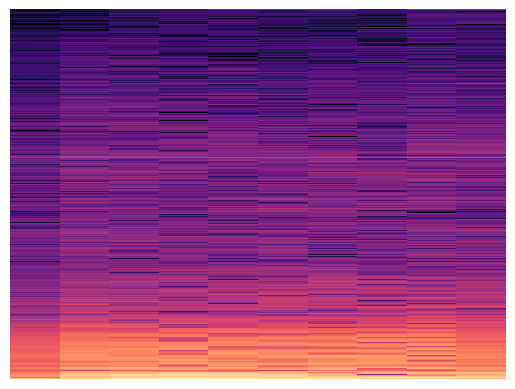

In [26]:
# data = X_ptb.values[1]

# D = np.abs(librosa.stft(data))
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
# plt.axis('off') 
# plt.show()